#**PROJECT NAME** : **Email Spam Detection**

* We’ve all been the recipient of spam emails before. Spam mail, or junk mail, is a type of email that is sent to a massive number of users at one time, frequently containing cryptic messages, scams, or most dangerously, phishing content.


* Building an email spam detector. Then, use machine learning to train the spam detector to recognize and classify emails into spam and non-spam. Let’s get started!

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import nltk
sns.set(style= 'darkgrid')

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
!pip install catboost
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.5 MB/s eta 0:00:00


## Loading Dataset

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Oasis Infobyte/Project 4/spam.csv', encoding= 'ISO-8859-1')  # 'Latin-1','Latin1 / latin1'

## Understanding the Data / Data Inspection

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
print(f'No. of Columns: {df.shape[1]}')
print(f'No. of Rows: {df.shape[0]}')
df.shape

No. of Columns: 5
No. of Rows: 5572


(5572, 5)

In [5]:
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [7]:
# Descriptive Analysis
df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


## Data Cleaning

In [8]:
# Checking Null Values
df.isna().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

* Let's drop Unnamed:2, Unnamed:3, Unnamed:4 columns with too much null values and these columns are unnecessary / non-relavant.

In [9]:
# Drop Columns
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis= 1, inplace= True)

In [10]:
# Checking Duplicates
df.duplicated().sum()

403

In [11]:
# Checking & Identifying Duplicates
df[df.duplicated()] # df[df.duplicated() == True]

,v1,v2
102,ham,As per your request 'Melle Melle (Oru Minnamin...
153,ham,As per your request 'Melle Melle (Oru Minnamin...
206,ham,"As I entered my cabin my PA said, '' Happy B'd..."
222,ham,"Sorry, I'll call later"
325,ham,No calls..messages..missed calls
...,...,...
5524,spam,You are awarded a SiPix Digital Camera! call 0...
5535,ham,"I know you are thinkin malaria. But relax, chi..."
5539,ham,Just sleeping..and surfing
5553,ham,Hahaha..use your brain dear


In [12]:
# Remove Duplicated Values
df.drop_duplicates(inplace= True)
df.duplicated().sum()

0

## Data Formating

In [13]:
# Renaming the columns for better readability
df.columns = ['target', 'text']               # df.rename(columns= {'v1' : 'target', 'v2' : 'text'}, inplace= True)

## **Predictive Analysis**

Let's start building different Machine Learning models and train them.

ham     4516
spam     653
Name: target, dtype: int64


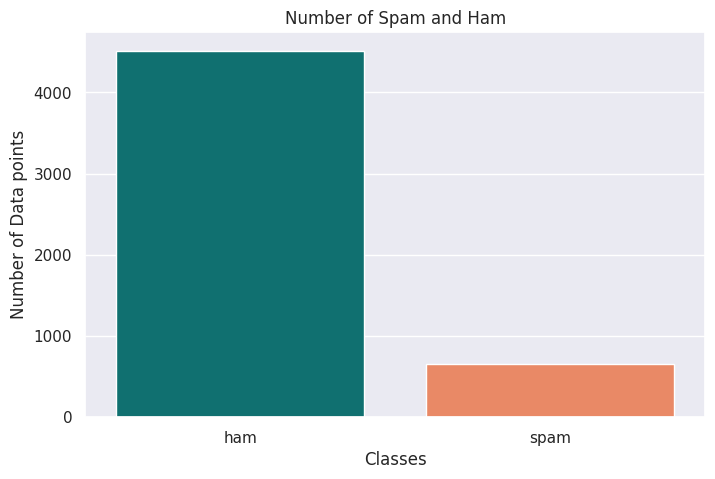

In [14]:
# Plotting and Checking if the data is imbalanced or not
data_bal = df['target'].value_counts()
print(data_bal)

plt.figure(figsize= (8,5))
fig = sns.countplot(df, x= 'target', palette= ['teal','coral'])
fig.set_title('Number of Spam and Ham')
fig.set_xlabel('Classes')
fig.set_ylabel('Number of Data points')
plt.show()

### Data Preprocessing

* Text Cleaning: Remove unnecessary characters, stopwords, and apply stemming or lemmatization.
* Vectorization: Convert text data into numerical format using techniques like TF-IDF or CountVectorizer, which are essential for machine learning models to process text data.


Text Cleaning

In [15]:
# Function to clean text data

# Download stopwords
nltk.download('stopwords')

def clean_text(text):
  ''' Remove punctuation and numbers '''
  text = re.sub('[^a-zA-Z]', ' ', text)
  ''' Convert text to lowercase '''
  text = text.lower()
  ''' Remove stopwords '''
  stop_words = set(stopwords.words('english'))
  text = ' '.join([word for word in text.split() if word not in stop_words])
  ''' stemming '''
  stemmer = PorterStemmer()
  text = ' '.join([stemmer.stem(word) for word in text.split()])
  return text

# Apply the cleaning function to the text messages
df['text'] = df['text'].apply(clean_text)
# Display cleaned dataset
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,target,text
0,ham,go jurong point crazi avail bugi n great world...
1,ham,ok lar joke wif u oni
2,spam,free entri wkli comp win fa cup final tkt st m...
3,ham,u dun say earli hor u c alreadi say
4,ham,nah think goe usf live around though


The text data has been successfully cleaned:

* Removing punctuation and numbers, leaving only letters.
* Converting all text to lowercase to ensure uniformity.
* Removing common English stopwords (e.g., "the", "is", "in") that do not contribute much to the meaning of the messages.
* Applying stemming to reduce words to their base or root form, which helps in generalizing different forms of the same word.

Vectorization

In [16]:
# Vectorizing the cleaned text data using TF-IDF
vectorizer = TfidfVectorizer()
vectorized_text = vectorizer.fit_transform(df['text']).toarray()

In [17]:
vectorized_text

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
vectorized_text.shape

(5169, 6221)

* This indicates that our dataset has been vectorized into a space with 6221 features, which corresponds to the unique words identified by the TF-IDF vectorizer after preprocessing the text data.

Feature Engineering

In [19]:
# Label Encoding
encoder = LabelEncoder()                            # Convert labels to numerical format
df['target'] = encoder.fit_transform(df['target'])  # df['v1'] = df['v1'].map({'ham' : 0, 'spam' : 1})
dicv1 = dict(enumerate(encoder.classes_))
print(dicv1)

{0: 'ham', 1: 'spam'}


In [20]:
# Select and define features(x) and target variable(y)
x = vectorized_text                                     # x = vectorizer.fit_transform(df['v2']).toarray()
y = df['target']                                        # y = df['v1'].map({'ham' : 0, 'spam' : 1})

In [21]:
x[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
y[:5]

0    0
1    0
2    1
3    0
4    0
Name: target, dtype: int64

Data Spliting

In [23]:
# Splitting the dataset into training and testing parts
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state= 42)

In [24]:
# Display the shape of the training and testing sets
print('Training set shape: ', x_train.shape)
print('Testing set shape: ', x_test.shape)

Training set shape:  (4135, 6221)
Testing set shape:  (1034, 6221)


### Model Building

In [25]:
# Logistic Regression
log_reg = LogisticRegression(random_state= 42)
log_reg.fit(x_train, y_train)
y_pred_log = log_reg.predict(x_test)
print(log_reg.score(x_train, y_train))

# Naive_Bayes
nb_model = MultinomialNB()
nb_model.fit(x_train, y_train)
y_pred_nb = nb_model.predict(x_test)
print(nb_model.score(x_train, y_train))

# Neural Network
nn_model = MLPClassifier()
nn_model.fit(x_train, y_train)
y_pred_nn = nn_model.predict(x_test)
print(nn_model.score(x_train, y_train))

# Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(x_train, y_train)
y_pred_dt = dt_model.predict(x_test)
print(dt_model.score(x_train, y_train))

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(x_train, y_train)
y_pred_rf = rf_model.predict(x_test)
print(rf_model.score(x_train, y_train))

# K-Neighbors
kn_model = KNeighborsClassifier()
kn_model.fit(x_train, y_train)
y_pred_kn = kn_model.predict(x_test)
print(kn_model.score(x_train, y_train))

# SVM
svm_model = SVC()
svm_model.fit(x_train, y_train)
y_pred_svm = svm_model.predict(x_test)
print(svm_model.score(x_train, y_train))


0.9680773881499395
0.9692865779927449
1.0
1.0
0.999758162031439
0.9252720677146312
0.9970979443772672


In [26]:
# LightGBM
lgbm_model = LGBMClassifier()
lgbm_model.fit(x_train, y_train)
y_pred_lgbm = lgbm_model.predict(x_test)
print(lgbm_model.score(x_train, y_train))

# XGboost
xgb_model = XGBClassifier()
xgb_model.fit(x_train, y_train)
y_pred_xgb = xgb_model.predict(x_test)
print(xgb_model.score(x_train, y_train))

# Catboost
cat_model = CatBoostClassifier(verbose= False)
cat_model.fit(x_train, y_train)
y_pred_cat = cat_model.predict(x_test)
print(cat_model.score(x_train, y_train))


[LightGBM] [Info] Number of positive: 508, number of negative: 3627
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6667
[LightGBM] [Info] Number of data points in the train set: 4135, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122854 -> initscore=-1.965680
[LightGBM] [Info] Start training from score -1.965680
0.9990326481257558
0.9908101571946796
0.9881499395405079


### Model Evaluation

Logistic Regression

In [27]:
# Logistic Regression
print('The performance evaluation of Logistic Regression Model is below: ', '\n')
print('Accuracy Score: ', accuracy_score(y_test, y_pred_log), '\n')
print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_pred_log), '\n')
print('Classification Report: ', '\n', classification_report(y_test, y_pred_log,  target_names= ['ham', 'spam']), '\n')

The performance evaluation of Logistic Regression Model is below:  

Accuracy Score:  0.9555125725338491 

Confusion Matrix:  
 [[883   6]
 [ 40 105]] 

Classification Report:  
               precision    recall  f1-score   support

         ham       0.96      0.99      0.97       889
        spam       0.95      0.72      0.82       145

    accuracy                           0.96      1034
   macro avg       0.95      0.86      0.90      1034
weighted avg       0.96      0.96      0.95      1034
 



Naive_Bayes

In [28]:
# Naive_Bayes
print('The performance evaluation of Naive Bayes Model is below: ', '\n')
print('Accuracy Score: ', accuracy_score(y_test, y_pred_nb), '\n')
print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_pred_nb), '\n')
print('Classification Report: ', '\n', classification_report(y_test, y_pred_nb,  target_names= ['ham', 'spam']), '\n')

The performance evaluation of Naive Bayes Model is below:  

Accuracy Score:  0.9671179883945842 

Confusion Matrix:  
 [[888   1]
 [ 33 112]] 

Classification Report:  
               precision    recall  f1-score   support

         ham       0.96      1.00      0.98       889
        spam       0.99      0.77      0.87       145

    accuracy                           0.97      1034
   macro avg       0.98      0.89      0.92      1034
weighted avg       0.97      0.97      0.97      1034
 



Neural Network

In [29]:
# Neural Network
print('The performance evaluation of Neural Network Model is below: ', '\n')
print('Accuracy Score: ', accuracy_score(y_test, y_pred_nn), '\n')
print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_pred_nn), '\n')
print('Classification Report: ', '\n', classification_report(y_test, y_pred_nn,  target_names= ['ham', 'spam']), '\n')

The performance evaluation of Neural Network Model is below:  

Accuracy Score:  0.9787234042553191 

Confusion Matrix:  
 [[884   5]
 [ 17 128]] 

Classification Report:  
               precision    recall  f1-score   support

         ham       0.98      0.99      0.99       889
        spam       0.96      0.88      0.92       145

    accuracy                           0.98      1034
   macro avg       0.97      0.94      0.95      1034
weighted avg       0.98      0.98      0.98      1034
 



Decision Tree Model

In [30]:
# Decision Tree
print('The performance evaluation of Decision Tree Model is below: ', '\n')
print('Accuracy Score: ', accuracy_score(y_test, y_pred_dt), '\n')
print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_pred_dt), '\n')
print('Classification Report: ', '\n', classification_report(y_test, y_pred_dt,  target_names= ['ham', 'spam']), '\n')

The performance evaluation of Decision Tree Model is below:  

Accuracy Score:  0.9622823984526112 

Confusion Matrix:  
 [[869  20]
 [ 19 126]] 

Classification Report:  
               precision    recall  f1-score   support

         ham       0.98      0.98      0.98       889
        spam       0.86      0.87      0.87       145

    accuracy                           0.96      1034
   macro avg       0.92      0.92      0.92      1034
weighted avg       0.96      0.96      0.96      1034
 



Random Forest

In [31]:
# Random Forest
print('The performance evaluation of Random Forest Model is below: ', '\n')
print('Accuracy Score: ', accuracy_score(y_test, y_pred_rf), '\n')
print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_pred_rf), '\n')
print('Classification Report: ', '\n', classification_report(y_test, y_pred_rf,  target_names= ['ham', 'spam']), '\n')

The performance evaluation of Random Forest Model is below:  

Accuracy Score:  0.9748549323017408 

Confusion Matrix:  
 [[889   0]
 [ 26 119]] 

Classification Report:  
               precision    recall  f1-score   support

         ham       0.97      1.00      0.99       889
        spam       1.00      0.82      0.90       145

    accuracy                           0.97      1034
   macro avg       0.99      0.91      0.94      1034
weighted avg       0.98      0.97      0.97      1034
 



K-Neighbors

In [32]:
# K-Neighbors
print('The performance evaluation of K-Neighbors Model is below: ', '\n')
print('Accuracy Score: ', accuracy_score(y_test, y_pred_kn), '\n')
print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_pred_kn), '\n')
print('Classification Report: ', '\n', classification_report(y_test, y_pred_kn,  target_names= ['ham', 'spam']), '\n')

The performance evaluation of K-Neighbors Model is below:  

Accuracy Score:  0.9081237911025145 

Confusion Matrix:  
 [[889   0]
 [ 95  50]] 

Classification Report:  
               precision    recall  f1-score   support

         ham       0.90      1.00      0.95       889
        spam       1.00      0.34      0.51       145

    accuracy                           0.91      1034
   macro avg       0.95      0.67      0.73      1034
weighted avg       0.92      0.91      0.89      1034
 



SVM

In [33]:
# SVM
print('The performance evaluation of SVM Model is below: ', '\n')
print('Accuracy Score: ', accuracy_score(y_test, y_pred_svm), '\n')
print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_pred_svm), '\n')
print('Classification Report: ', '\n', classification_report(y_test, y_pred_svm,  target_names= ['ham', 'spam']), '\n')

The performance evaluation of SVM Model is below:  

Accuracy Score:  0.9758220502901354 

Confusion Matrix:  
 [[889   0]
 [ 25 120]] 

Classification Report:  
               precision    recall  f1-score   support

         ham       0.97      1.00      0.99       889
        spam       1.00      0.83      0.91       145

    accuracy                           0.98      1034
   macro avg       0.99      0.91      0.95      1034
weighted avg       0.98      0.98      0.97      1034
 



LightGBM

In [34]:
# LightGBM
print('The performance evaluation of LghtGBM Model is below: ', '\n')
print('Accuracy Score: ', accuracy_score(y_test, y_pred_lgbm), '\n')
print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_pred_lgbm), '\n')
print('Classification Report: ', '\n', classification_report(y_test, y_pred_lgbm,  target_names= ['ham', 'spam']), '\n')

The performance evaluation of LghtGBM Model is below:  

Accuracy Score:  0.9816247582205029 

Confusion Matrix:  
 [[881   8]
 [ 11 134]] 

Classification Report:  
               precision    recall  f1-score   support

         ham       0.99      0.99      0.99       889
        spam       0.94      0.92      0.93       145

    accuracy                           0.98      1034
   macro avg       0.97      0.96      0.96      1034
weighted avg       0.98      0.98      0.98      1034
 



XGboost

In [35]:
# XGboost
print('The performance evaluation of XGboost Model is below: ', '\n')
print('Accuracy Score: ', accuracy_score(y_test, y_pred_xgb), '\n')
print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_pred_xgb), '\n')
print('Classification Report: ', '\n', classification_report(y_test, y_pred_xgb,  target_names= ['ham', 'spam']), '\n')

The performance evaluation of XGboost Model is below:  

Accuracy Score:  0.9748549323017408 

Confusion Matrix:  
 [[879  10]
 [ 16 129]] 

Classification Report:  
               precision    recall  f1-score   support

         ham       0.98      0.99      0.99       889
        spam       0.93      0.89      0.91       145

    accuracy                           0.97      1034
   macro avg       0.96      0.94      0.95      1034
weighted avg       0.97      0.97      0.97      1034
 



Catboost

In [36]:
# Catboost
print('The performance evaluation of Catboost Model is below: ', '\n')
print('Accuracy Score: ', accuracy_score(y_test, y_pred_cat), '\n')
print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_pred_cat), '\n')
print('Classification Report: ', '\n', classification_report(y_test, y_pred_cat,  target_names= ['ham', 'spam']), '\n')

The performance evaluation of Catboost Model is below:  

Accuracy Score:  0.9787234042553191 

Confusion Matrix:  
 [[889   0]
 [ 22 123]] 

Classification Report:  
               precision    recall  f1-score   support

         ham       0.98      1.00      0.99       889
        spam       1.00      0.85      0.92       145

    accuracy                           0.98      1034
   macro avg       0.99      0.92      0.95      1034
weighted avg       0.98      0.98      0.98      1034
 



Actual Output vs Predicted Output

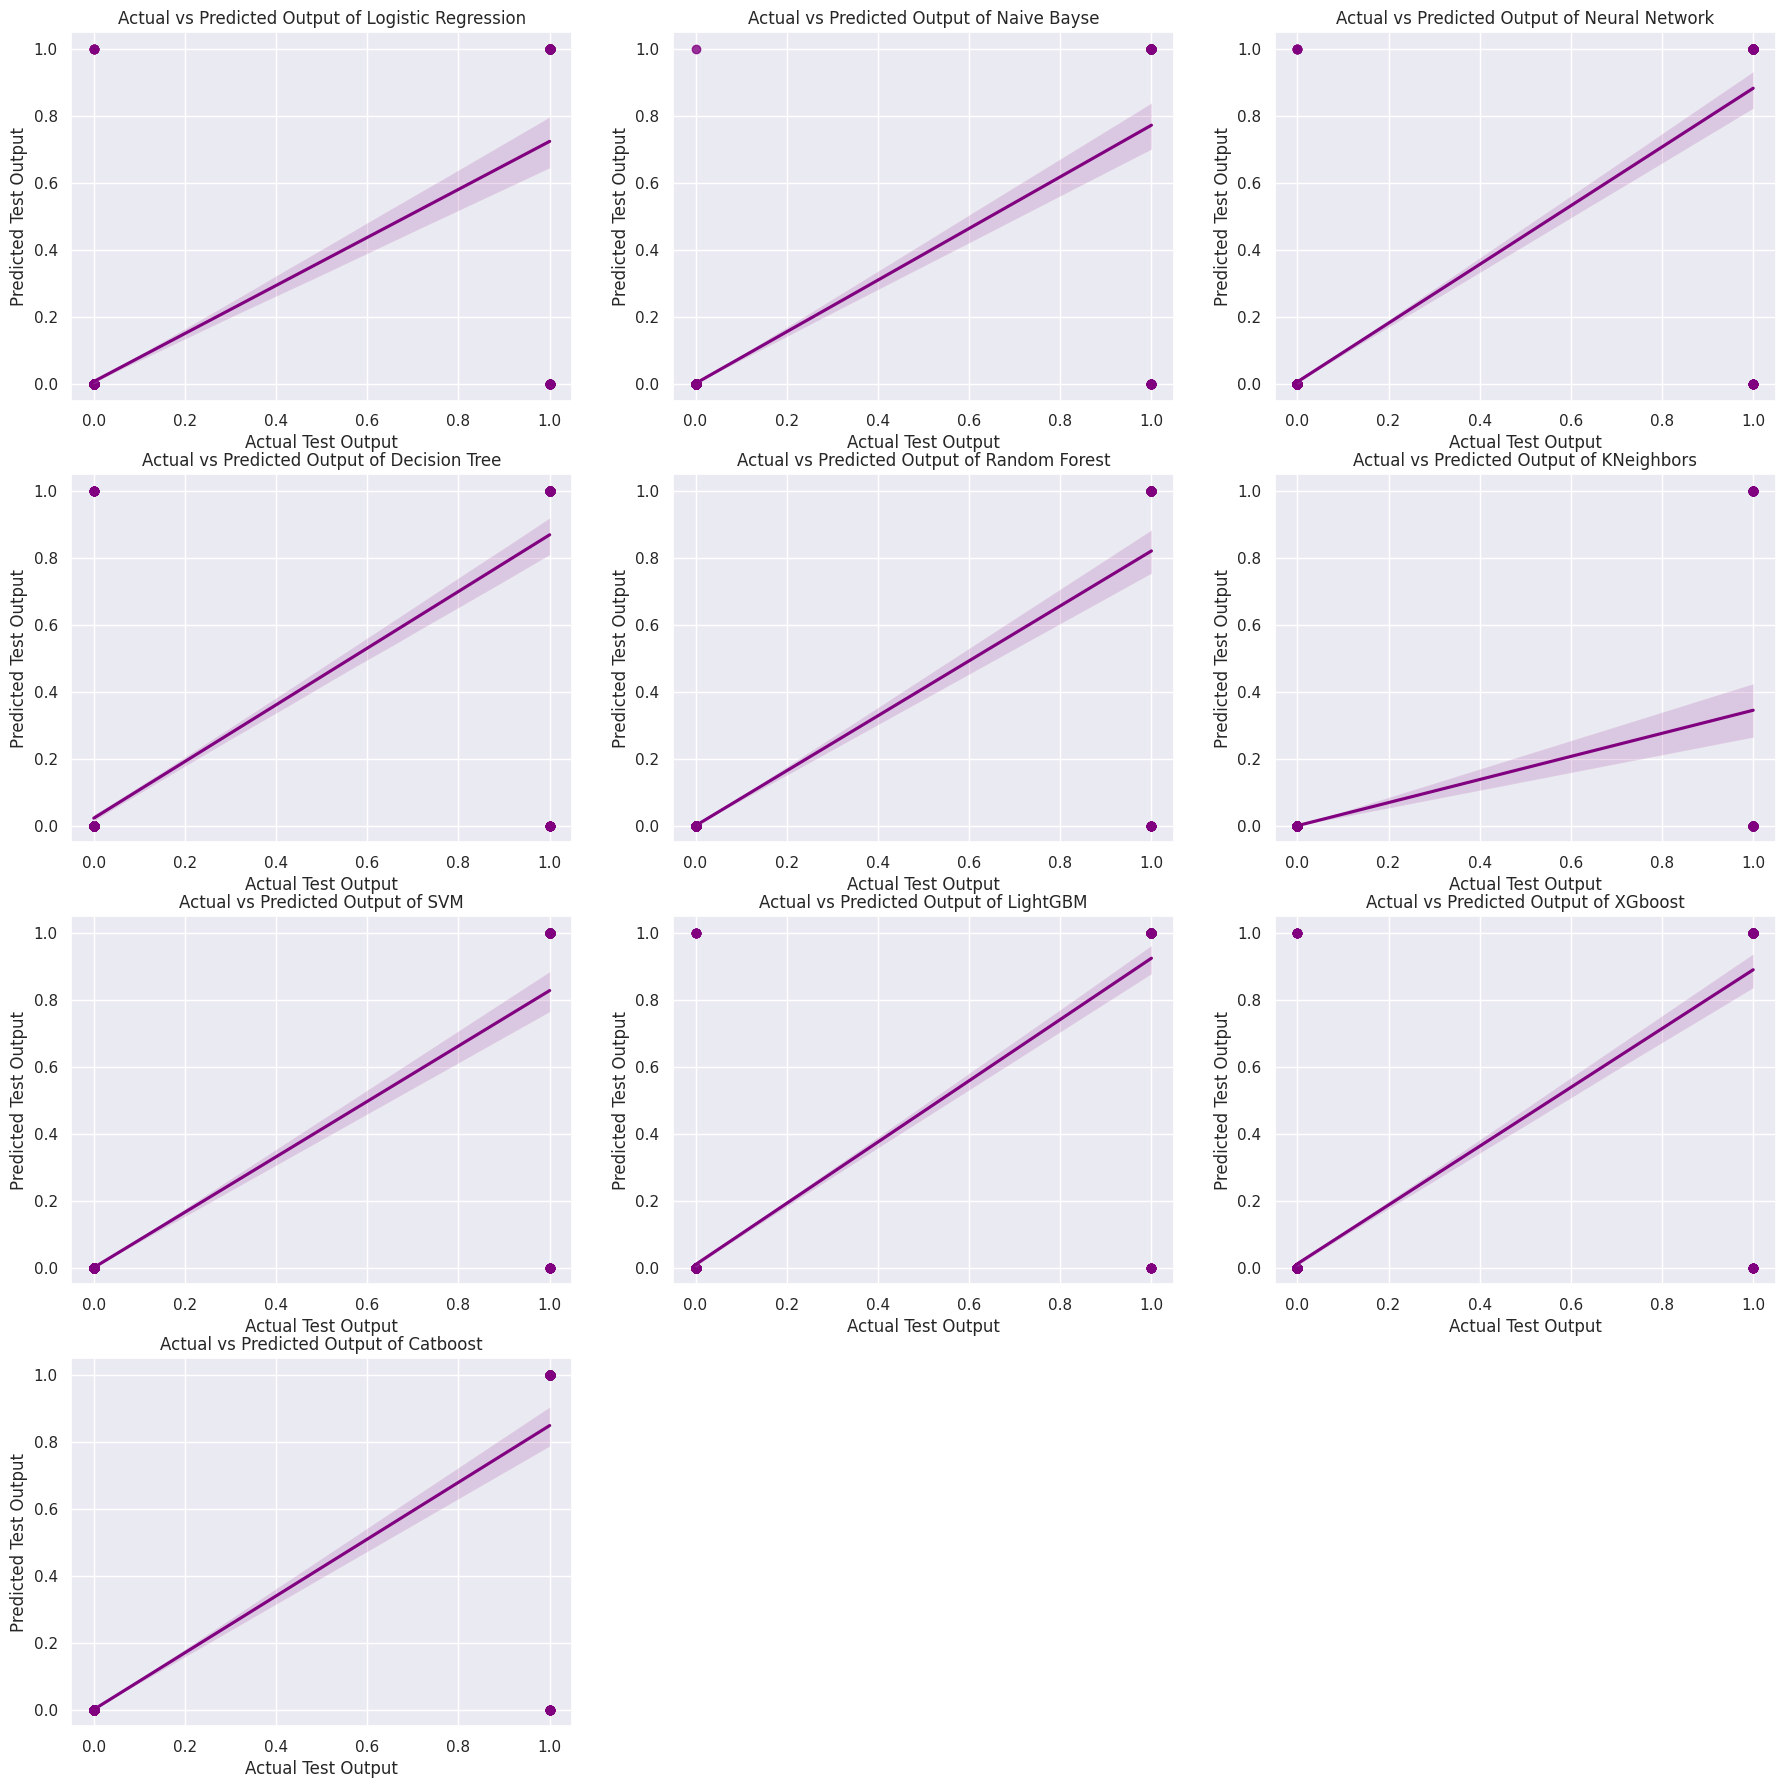

In [37]:
predictions = [y_pred_log, y_pred_nb, y_pred_nn, y_pred_dt, y_pred_rf, y_pred_kn, y_pred_svm, y_pred_lgbm, y_pred_xgb, y_pred_cat]
classifiers_name = ['Logistic Regression', 'Naive Bayse', 'Neural Network', 'Decision Tree', 'Random Forest',
               'KNeighbors', 'SVM', 'LightGBM', 'XGboost', 'Catboost']

plt.figure(figsize=(22,22))
for i, pred in enumerate(predictions):
  plt.subplot(4,3,i+1)
  sns.regplot(x= y_test, y= pred, color= 'purple')
  plt.title(f'Actual vs Predicted Output of {classifiers_name[i]}')
  plt.xlabel('Actual Test Output')
  plt.ylabel('Predicted Test Output')


.\
.

### Model Building (For-Loop)

In [38]:
# Creating a list of models
models = [LogisticRegression(random_state= 42),
          MultinomialNB(),
          MLPClassifier(),
          DecisionTreeClassifier(),
          RandomForestClassifier(),
          KNeighborsClassifier(),
          SVC(),
          LGBMClassifier(),
          XGBClassifier(),
          CatBoostClassifier(verbose= False)]

for model in models:
  model.fit(x_train, y_train)

[LightGBM] [Info] Number of positive: 508, number of negative: 3627
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6667
[LightGBM] [Info] Number of data points in the train set: 4135, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122854 -> initscore=-1.965680
[LightGBM] [Info] Start training from score -1.965680


In [ ]:
predictions = [y_pred_log1, y_pred_nb1, y_pred_nn1, y_pred_dt1, y_pred_rf1, y_pred_kn1, y_pred_svm1, y_pred_lgbm1, y_pred_xgb1, y_pred_cat1]

for i in range(1, len(models)):
  predictions[i] = models[i-1].predict(x_test)
  print(models[i-1].score(x_train, y_train))

In [ ]:
print(classification_report(y_test, y_pred_log1))